In [1]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
from PAOFLOW import PAOFLOW
from scipy.linalg import eigh
warnings.filterwarnings("ignore")

## Plotters

In [2]:
def plot_hamiltonian_overlap(H, S, cmap, norm, title_H="H Matrix", title_S="S Matrix"):
    """
    Plot the Hamiltonian and Overlap matrices with a shared colorbar and customized color mapping.

    Parameters:
    - H: np.ndarray, Hamiltonian matrix to visualize.
    - S: np.ndarray, Overlap matrix to visualize.
    - cmap: Colormap, the colormap for the plot.
    - norm: Normalization, the normalization for color mapping.
    - title_H: str, Title for the Hamiltonian plot.
    - title_S: str, Title for the Overlap plot.

    Returns:
    - None, displays the plots.
    """
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot H matrix
    cax1 = axs[0].imshow(np.abs(H), interpolation="nearest", cmap=cmap, norm=norm)
    axs[0].set_title(title_H)

    # Plot S matrix
    cax2 = axs[1].imshow(np.abs(S), interpolation="nearest", cmap=cmap, norm=norm)
    axs[1].set_title(title_S)

    # Add a single colorbar shared by both subplots
    cbar = fig.colorbar(cax2, ax=axs, orientation="vertical", fraction=0.03, pad=0.04)
    cbar.set_label("Energy (eV)")

    # plt.tight_layout()
    plt.show()


def plot_orbital_energies(
    H, S, fermi_level=0, n_valence=1, n_conduction=3, title="Orbital Energies"
):
    """Plot eigenvalues around the Fermi level."""
    eigenvalues, _ = eigh(H, S)
    fermi_index = np.argmin(np.abs(eigenvalues - fermi_level))
    start_index = max(fermi_index - n_valence, 0)
    end_index = min(fermi_index + n_conduction + 1, len(eigenvalues))
    selected_indices = np.arange(start_index, end_index)

    plt.figure(figsize=(8, 6))
    x_min, x_max = -0.5, 0.5

    for idx in selected_indices:
        energy = eigenvalues[idx]
        plt.hlines(energy, x_min, x_max, colors="blue", linestyles="--")
    plt.axhline(0, color="red", linestyle="--", label="Fermi Level")

    plt.title(title)
    plt.ylabel("Energy (eV)")
    plt.legend()
    plt.grid(True)
    plt.show()


### Helper functions

In [3]:
def print_largest_non_diagonal_elements(S, n=3):
    """
    Prints the n largest non-diagonal absolute values from an overlap matrix.

    Parameters:
    - S: np.ndarray, the overlap matrix.
    - n: int, the number of largest non-diagonal elements to print.

    Returns:
    - None, prints the largest values and their indices.
    """
    # Ensure the input matrix is square
    assert S.shape[0] == S.shape[1], "The overlap matrix must be square."

    # Get absolute values and remove the diagonal by setting it to zero
    abs_S = np.abs(S)
    np.fill_diagonal(abs_S, 0)

    # Find the indices of the largest elements
    flat_indices = np.argsort(abs_S, axis=None)[-n:]
    row_indices, col_indices = np.unravel_index(flat_indices, S.shape)
    largest_values = abs_S[row_indices, col_indices]

    # Print the results
    print(f"The {n} largest non-diagonal elements in the overlap matrix are:")
    for i in range(n):
        print(
            f"Value: {largest_values[i]:.4f} at indices ({row_indices[i]}, {col_indices[i]})"
        )


def get_species_indices(atoms, species):
    indices = []
    for element in species:
        element_indices = atoms.symbols.search(element)
        indices.extend(element_indices)
    return sorted(indices)


def create_active_hamiltonian(H, S, index_active_region):
    # Create a list of indices to retain
    indices_to_keep = sorted(list(index_active_region))

    # Create the H_active matrix by extracting the relevant rows and columns
    H_active = H[np.ix_(indices_to_keep, indices_to_keep)]
    S_active = S[np.ix_(indices_to_keep, indices_to_keep)]

    return H_active, S_active


def calculate_homo_lumo(H, S, homo_index, lumo_index):
    """Calculate HOMO, LUMO, and the HOMO-LUMO gap."""
    eigenvalues, _ = eigh(H, S)
    homo_energy = eigenvalues[homo_index]
    lumo_energy = eigenvalues[lumo_index]
    homo_lumo_gap = lumo_energy - homo_energy

    return homo_energy, lumo_energy, homo_lumo_gap


def check_unitary(matrix, tol=1e-2):
    """
    Check if a matrix is unitary.

    Parameters:
    matrix (np.ndarray): The matrix to check.
    tol (float): Tolerance for checking numerical equality.

    Returns:
    bool: True if the matrix is unitary, False otherwise.
    """
    # Calculate the conjugate transpose
    conjugate_transpose = np.conjugate(matrix.T)

    # Compute U†U
    product = np.dot(conjugate_transpose, matrix)
    # Compare with the identity matrix
    identity = np.eye(matrix.shape[0])
    return np.allclose(product, identity, atol=tol)


def check_hermitian(matrix, tol=1e-2):
    """
    Check if a matrix is Hermitian.

    Parameters:
    matrix (np.ndarray): The matrix to check.
    tol (float): Tolerance for checking numerical equality.

    Returns:
    bool: True if the matrix is Hermitian, False otherwise.
    """
    # Calculate the conjugate transpose
    conjugate_transpose = np.conjugate(matrix.T)
    # Compare with the original matrix
    return np.allclose(matrix, conjugate_transpose, atol=tol)


HOMO-LUMO gap Quantum Espresso (PW) = 5.1381 eV

HOMO-LUMO gap PAOFLOW (LCAOs) = 5.1383 eV

HOMO-LUMO gap qtpyt (LOs) full space = 5.14176 eV

HOMO-LUMO gap qtpyt (LOs) C 2pz space = 5.14176 eV


### PW to LCAO

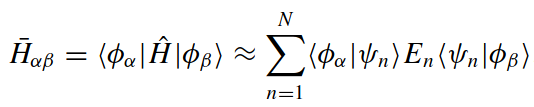

In [4]:
paoflow = PAOFLOW.PAOFLOW(savedir='/home/anooja/Desktop/los-dmrg/tests/benzene/qe/out/aiida.save', model=None, outputdir='/home/anooja/Desktop/los-dmrg/tests/benzene/paoflow', smearing='gauss',verbose=True)
data_controller = paoflow.data_controller
arry,attr = paoflow.data_controller.data_dicts()


#############################################################################################
#                                                                                           #
#                                          PAOFLOW                                          #
#                                                                                           #
#                  Utility to construct and operate on Hamiltonians from                    #
#                 the Projections of DFT wfc on Atomic Orbital bases (PAO)                  #
#                                                                                           #
#                       (c)2016-2024 ERMES group (http://ermes.unt.edu)                     #
#############################################################################################

Monkhorst and Pack grid: 1 1 1 0 0 0
Insulator: True
Magnetic: False
Number of kpoints: 1
Number of electrons: 30.000000
Number of bands: 19
SciPy will 

In [5]:
paoflow.projections()

atom: C   pseudo: C.pbesol-n-kjpaw_psl.1.0.0.UPF  tau: [15.86166997 13.22809756  9.44863054]
      atwfc:   1  2S  l=0, m=1
      atwfc:   2  2P  l=1, m=1
      atwfc:   3  2P  l=1, m=2
      atwfc:   4  2P  l=1, m=3
atom: C   pseudo: C.pbesol-n-kjpaw_psl.1.0.0.UPF  tau: [14.54487656 15.50888255  9.44863054]
      atwfc:   5  2S  l=0, m=1
      atwfc:   6  2P  l=1, m=1
      atwfc:   7  2P  l=1, m=2
      atwfc:   8  2P  l=1, m=3
atom: C   pseudo: C.pbesol-n-kjpaw_psl.1.0.0.UPF  tau: [11.91126374 15.50889673  9.44863054]
      atwfc:   9  2S  l=0, m=1
      atwfc:  10  2P  l=1, m=1
      atwfc:  11  2P  l=1, m=2
      atwfc:  12  2P  l=1, m=3
atom: C   pseudo: C.pbesol-n-kjpaw_psl.1.0.0.UPF  tau: [10.59446244 13.22809256  9.44863054]
      atwfc:  13  2S  l=0, m=1
      atwfc:  14  2P  l=1, m=1
      atwfc:  15  2P  l=1, m=2
      atwfc:  16  2P  l=1, m=3
atom: C   pseudo: C.pbesol-n-kjpaw_psl.1.0.0.UPF  tau: [11.91127087 10.94731076  9.44863054]
      atwfc:  17  2S  l=0, m=1
      at

In [6]:
# build the paoflow bands
paoflow.projectability(pthr=0.9)

Projectability vector  [0.98347373 0.98517242 0.98541747 0.97826427 0.9782644  0.96589947
 0.98663559 0.98382099 0.9801185  0.97944899 0.97723149 0.99241522
 0.99241558 0.99714987 0.99714986 0.94158916 0.94174299 0.26615988
 0.17966681]
# of bands with good projectability > 0.9 = 17
Range of suggested shift  4.4257121885227875  ,  4.4257121885227875
Projectability in:                          0.005 sec


In [7]:
paoflow.read_atomic_proj_QE()

In [8]:
paoflow.pao_hamiltonian()
# arry["HRs"] has dimensions (nawf,nawf,nk1,nk2,nk3,nspin)
H_lcao = arry["HRs"][:,:,0,0,0,0]
S_lcao =  np.eye(H_lcao.shape[0]) # The lcao Hamiltonian is Lowdin orthonormalized. Setting overlap to identity

Building Hks in:                            0.038 sec
k -> R in:                                  0.003 sec


Bands in:                                   0.192 sec


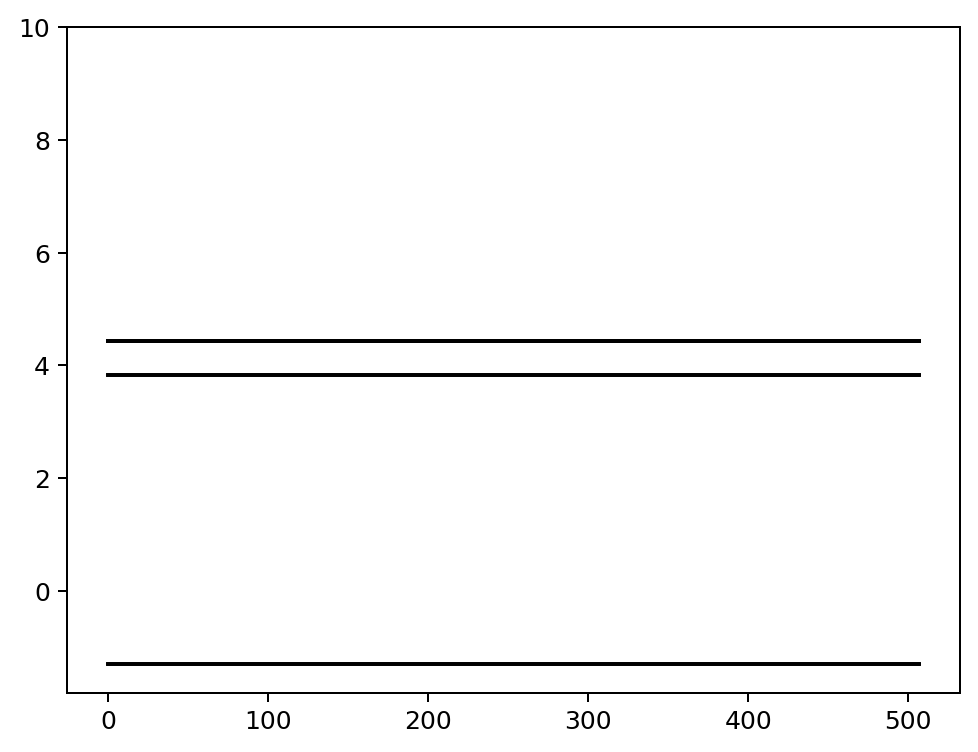

In [9]:
paoflow.bands(ibrav=2, nk=500)
fig = plt.figure(dpi=180)
# plot the paoflow bands
eband = arry['E_k']
for ib in range(eband.shape[1]):
    plt.plot(eband[:,ib],color='black')
plt.ylim(-1.8,10)
plt.show()

### LCAO to LOs

In [10]:
from qtpyt.basis import Basis
from qtpyt.lo.tools import rotate_matrix, subdiagonalize_atoms
from ase.io import read


In [11]:
atoms = read('./struct.xyz')
nao = [list(item.values())[0] for item in arry['nao']]
basis = Basis(atoms, nao)

SUBDIAG_SPECIES = ("C", "H")
subdiag_indices = get_species_indices(atoms, SUBDIAG_SPECIES)
# Extract the basis for the subdiagonalized region and get their indices
basis_subdiag_region = basis[subdiag_indices]
index_subdiag_region = basis_subdiag_region.get_indices()
Usub, eig = subdiagonalize_atoms(basis, H_lcao, S_lcao, a=subdiag_indices)

# Rotate matrices
H_subdiagonal = rotate_matrix(H_lcao, Usub)
S_subdiagonal = rotate_matrix(S_lcao, Usub)


In [12]:
from matplotlib.colors import LinearSegmentedColormap, LogNorm
cmap_name = 'custom_white_red'
colors = [(1, 1, 1), (166/255, 4/255, 4/255)]
n_bins = 100
cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
norm = LogNorm(vmin=0.1, vmax=10)

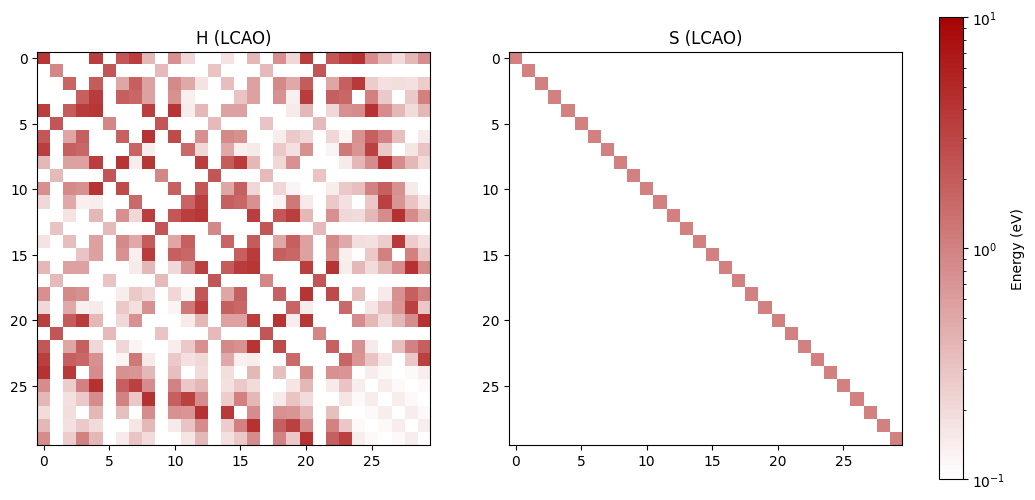

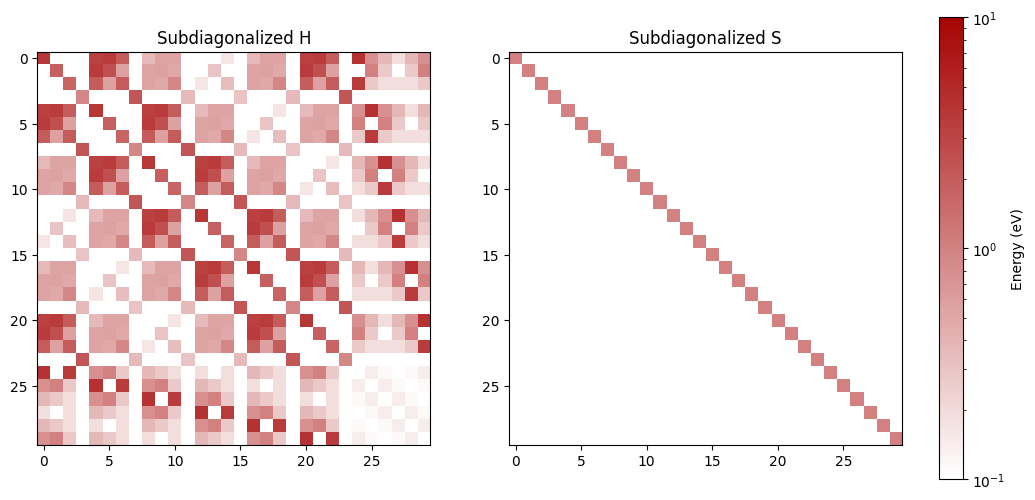

In [13]:
# Plot LCAO matrices
plot_hamiltonian_overlap(H_lcao, S_lcao, title_H="H (LCAO)", title_S="S (LCAO)", cmap=cmap, norm=norm)

# Plot subdiagonalized matrices
plot_hamiltonian_overlap(H_subdiagonal, S_subdiagonal, title_H="Subdiagonalized H", title_S="Subdiagonalized S", cmap=cmap, norm=norm)


In [31]:
# Define the active region within the subdiagonalized species (C 2 pz in this case)
active = {'C':[3]}
extract_active_region = basis_subdiag_region.extract().take(active)
index_active_region = index_subdiag_region[extract_active_region]


for idx in index_active_region:
    if Usub[idx-1,idx] < 0.: # change sign
        Usub[:,idx] *= -1

H_active, S_active = create_active_hamiltonian(H_subdiagonal, S_subdiagonal, index_active_region)

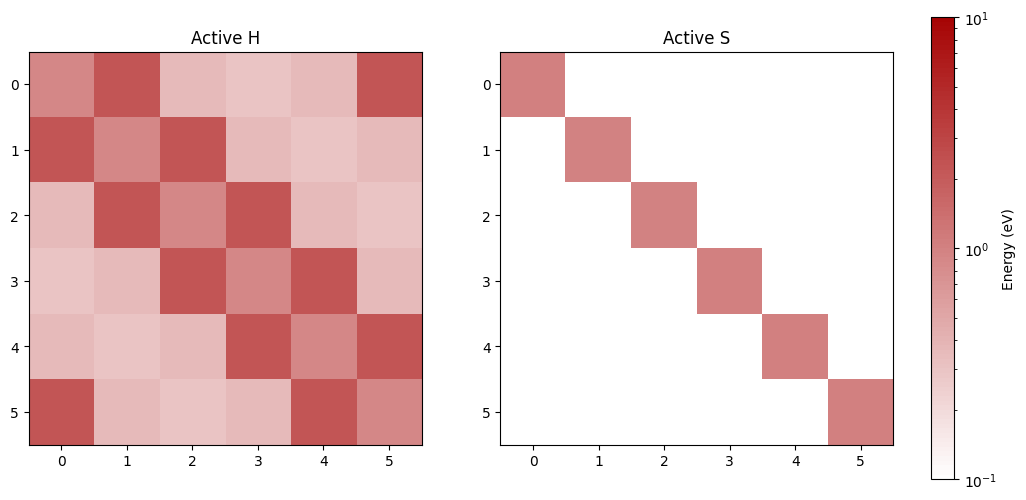

In [32]:
plot_hamiltonian_overlap(H_active, S_active, title_H="Active H", title_S="Active S", cmap=cmap, norm=norm)

HOMO energy: -1.3005261478312327 eV
LUMO energy: 3.8374817926334823 eV
HOMO-LUMO gap: 5.138007940464715 eV


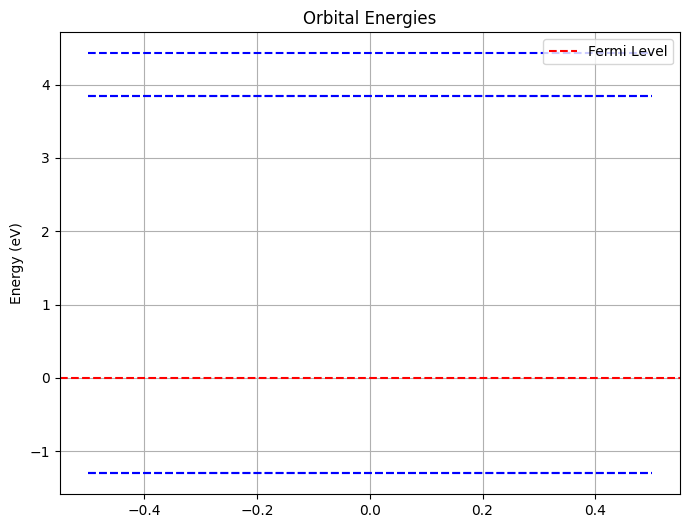

In [33]:
# Diagonalize the Hamiltonian and overlap matrices
eigenvalues, eigenvectors = eigh(H_subdiagonal, S_subdiagonal)
lumo_index = int(np.shape(H_subdiagonal)[0]/2)
homo_index = lumo_index - 1

# Calculate HOMO and LUMO energies, and gap
homo_energy, lumo_energy, homo_lumo_gap = calculate_homo_lumo(H_subdiagonal,S_subdiagonal,homo_index,lumo_index)
print(f"HOMO energy: {homo_energy} eV")
print(f"LUMO energy: {lumo_energy} eV")
print(f"HOMO-LUMO gap: {homo_lumo_gap} eV")

# Plot orbital energies around the Fermi level
plot_orbital_energies(H=H_subdiagonal, S=S_subdiagonal, fermi_level=0, n_valence=1, n_conduction=3)

HOMO energy: -1.3005261478312269 eV
LUMO energy: 3.837481792633487 eV
HOMO-LUMO gap: 5.138007940464714 eV


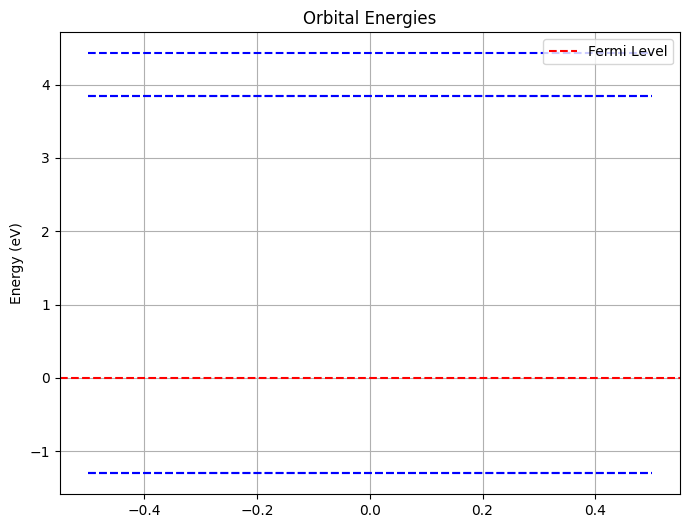

In [34]:
# # Diagonalize the Hermitian Hamiltonian using eigh (eigenvalues are automatically sorted)
eigenvalues, eigenvectors = eigh(H_active,S_active)

lumo_index_active = int(np.shape(H_active)[0]/2)
homo_index_active = lumo_index_active - 1

# Calculate HOMO and LUMO energies, and gap
homo_energy, lumo_energy, homo_lumo_gap = calculate_homo_lumo(H_active,S_active,homo_index_active,lumo_index_active)
print(f"HOMO energy: {homo_energy} eV")
print(f"LUMO energy: {lumo_energy} eV")
print(f"HOMO-LUMO gap: {homo_lumo_gap} eV")

# Plot orbital energies around the Fermi level
plot_orbital_energies(H=H_active, S=S_active, fermi_level=0, n_valence=1, n_conduction=3)


In [35]:
H_lcao

array([[-3.85558267e+00+0.00000000e+00j, -8.84463385e-09-6.72222471e-09j,
        -5.15050112e-02+6.94013770e-09j, -2.54841758e-05+4.60153800e-09j,
        -3.37014947e+00+1.51530595e-08j, -6.01172579e-08-1.64405879e-08j,
        -2.15656628e+00-1.53322229e-08j,  3.44701814e+00-4.81120508e-10j,
        -3.79261996e-01+1.81452994e-08j, -2.45006203e-08+3.35483629e-10j,
        -7.60073768e-01-2.63326208e-08j,  1.99832412e-01-1.88846440e-08j,
        -9.96305540e-03+1.56888005e-10j,  9.17140519e-10-8.70426674e-09j,
        -1.69625017e-01-5.64351224e-09j, -4.25827131e-07-1.89898958e-08j,
        -3.79253498e-01-3.32743178e-08j,  7.32463326e-08+3.83139514e-09j,
        -7.60076559e-01+1.50631337e-08j, -1.99834358e-01-8.26256825e-09j,
        -3.37010857e+00-1.06636245e-08j,  5.45539703e-10-1.01875139e-08j,
        -2.15653140e+00+6.10496613e-09j, -3.44701190e+00+6.39772556e-09j,
        -4.19596640e+00+1.72405959e-09j, -7.99834909e-01+6.79547560e-09j,
        -3.76866833e-01+1.52214375e-08

In [36]:
H_subdiagonal

array([[-3.85680605e+00-1.03397577e-25j,  1.01792151e-20-3.30872245e-24j,
        -3.23743208e-17-4.13590306e-24j, -1.39631941e-17-1.34948189e-18j,
        -3.27883290e+00-3.53574815e-08j, -3.57865962e+00+1.29102784e-02j,
         1.94039110e+00+8.35390675e-08j, -1.21619139e-07-1.54079776e-08j,
        -3.53287506e-01+1.21537808e-08j, -5.46735365e-01-1.27165807e-03j,
        -5.41214199e-01-8.51229934e-09j,  1.72728416e-08-1.19196996e-08j,
        -2.09267372e-03-3.76850246e-11j,  1.09947587e-05-5.96134040e-08j,
         1.61762900e-01+9.55033706e-09j, -8.61362014e-09-4.46632947e-10j,
        -3.53254117e-01-3.45758278e-08j, -5.46687447e-01-2.99599928e-04j,
        -5.41248217e-01+6.90958435e-08j,  6.31367342e-08-7.15289095e-09j,
        -3.27868085e+00-1.26029518e-08j, -3.57842808e+00-2.46665800e-03j,
         1.94072164e+00+2.64858187e-07j, -1.87550999e-08-2.46856202e-08j,
         4.28264817e+00-1.34775854e-08j,  7.93542476e-01-8.02528402e-09j,
         3.72481778e-01-1.51873119e-08

In [37]:
H_active

array([[ 0.90667035+0.00000000e+00j, -2.16972058-6.69072956e-01j,
         0.34911579-9.51182077e-02j,  0.19480113-2.26125384e-01j,
        -0.31957871-1.69574854e-01j, -0.29998727+2.25067504e+00j],
       [-2.16972058+6.69072956e-01j,  0.90670127+5.55111512e-17j,
         1.91761341-1.21595366e+00j, -0.1448711 +3.31503139e-01j,
         0.29321105+5.60030851e-02j,  0.06000889+3.56837700e-01j],
       [ 0.34911579+9.51182077e-02j,  1.91761341+1.21595366e+00j,
         0.90677487-5.55111512e-17j,  1.88204356-1.27018959e+00j,
         0.2638149 +2.47668430e-01j, -0.11586468+2.75192137e-01j],
       [ 0.19480113+2.26125384e-01j, -0.1448711 -3.31503139e-01j,
         1.88204356+1.27018959e+00j,  0.90668711-6.93889390e-18j,
        -0.50275191-2.21417206e+00j, -0.30293574+1.97873114e-01j],
       [-0.31957871+1.69574854e-01j,  0.29321105-5.60030851e-02j,
         0.2638149 -2.47668430e-01j, -0.50275191+2.21417206e+00j,
         0.90671282+2.77555756e-17j,  0.7899626 +2.12877892e+00j],
     